# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, to_date, col, from_unixtime,last, first, split, udf, when, avg, asc, desc, count, countDistinct
from pyspark.sql.types import LongType, TimestampType, IntegerType, StringType

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("sparkify")\
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
# load data
data_log = spark.read.json(path)
data_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [4]:
data_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Lets check how many missing values by each column:

In [5]:
Dict_Null = {col:data_log.filter(data_log[col].isNull()).count() for col in data_log.columns}
Dict_Null

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

The time is given in double for two columns th 'ts' and 'registration' columns. We need to convert hese columns to more appropriate type (Date)

In [6]:
# transform the dates to an appropriate format
data_log = data_log.withColumn('time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
data_log = data_log.withColumn('regtime', from_unixtime(col('registration').cast(LongType())/1000).cast(TimestampType()))
data_log.select("time","regtime").show(5)


+-------------------+-------------------+
|               time|            regtime|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-09-28 22:22:42|
|2018-10-01 00:03:00|2018-09-30 18:20:30|
|2018-10-01 00:06:34|2018-09-28 22:22:42|
|2018-10-01 00:06:56|2018-09-30 18:20:30|
|2018-10-01 00:11:16|2018-09-28 22:22:42|
+-------------------+-------------------+
only showing top 5 rows



The mini dataset is from 01-10-2018 to 03-12-2018, about two months of users information.

In [7]:
# the dataset timeline
start_time = data_log.agg({"time":"min"}).collect()[0][0]
end_time = data_log.agg({"time":"max"}).collect()[0][0]
print("the dataset timeline is from {} to {}".format(start_time.date(), end_time.date()))

the dataset timeline is from 2018-10-01 to 2018-12-03


Print the type of each column in the dataset

In [8]:
data_log.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('time', 'timestamp'),
 ('regtime', 'timestamp')]

The userId is given as a string, we need to cast the type to a double. We will do that later.

### 1 User information
Lets check information related to the user

In [9]:
data_log.select(['userId', 'firstName', 'lastName', 'gender', 'location', 'userAgent', 'level','regtime']).show(5)

+------+---------+--------+------+--------------------+--------------------+-----+-------------------+
|userId|firstName|lastName|gender|            location|           userAgent|level|            regtime|
+------+---------+--------+------+--------------------+--------------------+-----+-------------------+
|    30|    Colin| Freeman|     M|     Bakersfield, CA|Mozilla/5.0 (Wind...| paid|2018-09-28 22:22:42|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|"Mozilla/5.0 (Win...| free|2018-09-30 18:20:30|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|Mozilla/5.0 (Wind...| paid|2018-09-28 22:22:42|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|"Mozilla/5.0 (Win...| free|2018-09-30 18:20:30|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|Mozilla/5.0 (Wind...| paid|2018-09-28 22:22:42|
+------+---------+--------+------+--------------------+--------------------+-----+-------------------+
only showing top 5 rows



How many unique users

In [10]:
nusers = data_log.select("userId").distinct().count()
print("Number of users in the dataset: {} users".format(nusers))

Number of users in the dataset: 226 users


check if there are some empty string values ids

In [11]:
# Rows with empty strings in the 'userId' column.
data_log.where(data_log.userId == "").count()

8346

Let check the auth state of empty string users

In [12]:
data_log.filter(data_log.userId =="").groupBy("auth").count().toPandas()

,auth,count
0,Logged Out,8249
1,Guest,97


It is clear that empty Ids are related to users logged out or user as guests. Information about these users are missing and we need to drop them.

lets check how many males and females in this dataset

In [13]:
data_log.groupBy("gender").count().toPandas()

,gender,count
0,F,154578
1,None,8346
2,M,123576


None values number is the same as the empty string ids, which will be dropped later. In this subset females users of  are higher then males users.

How many paid and free accounts

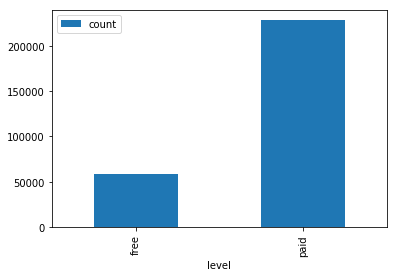

In [14]:
data_log.groupBy("level").count().toPandas().plot(kind='bar', x = 'level')

### Song information

In [15]:
data_log.select(['artist','song','length']).show(5)

+----------------+--------------------+---------+
|          artist|                song|   length|
+----------------+--------------------+---------+
|  Martha Tilston|           Rockpools|277.89016|
|Five Iron Frenzy|              Canada|236.09424|
|    Adam Lambert|   Time For Miracles| 282.8273|
|          Enigma|Knocking On Forbi...|262.71302|
|       Daft Punk|Harder Better Fas...|223.60771|
+----------------+--------------------+---------+
only showing top 5 rows



General songs information

In [16]:
# Number of songs
num_songs = data_log.select('song').distinct().count()
print("number of unique songs {}".format(num_songs))

number of unique songs 58481


In [17]:
# Number of artists
num_artists= data_log.select('artist').distinct().count()
print("number of unique artists {}".format(num_artists))

number of unique artists 17656


Show the most played songs

In [18]:
data_log.groupby('song', 'artist').count().orderBy("count", ascending=False).show(5)

+--------------+-------------+-----+
|          song|       artist|count|
+--------------+-------------+-----+
|          null|         null|58392|
|You're The One|Dwight Yoakam| 1122|
|          Undo|     BjÃÂ¶rk| 1026|
|       Revelry|Kings Of Leon|  854|
| Sehr kosmisch|     Harmonia|  728|
+--------------+-------------+-----+
only showing top 5 rows



We have 58392 missing values in song title information, and the most played song is You're The One of Dwight Yoakam.

Now lets check the most played artists

In [19]:
data_log.groupby('artist').count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
+--------------------+-----+
only showing top 5 rows



### Actions information
This part is the most important which shows how users logs and interact with Sparkify services

In [20]:
#  logs information
data_log.select(['time','sessionId', 'itemInSession', 'page', 'auth',  'method', 'status']).show(5)

+-------------------+---------+-------------+--------+---------+------+------+
|               time|sessionId|itemInSession|    page|     auth|method|status|
+-------------------+---------+-------------+--------+---------+------+------+
|2018-10-01 00:01:57|       29|           50|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:03:00|        8|           79|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:06:34|       29|           51|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:06:56|        8|           80|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:11:16|       29|           52|NextSong|Logged In|   PUT|   200|
+-------------------+---------+-------------+--------+---------+------+------+
only showing top 5 rows



In [21]:
# how many sessions
nu_sessions = data_log.select("sessionId").distinct().count()
print("number of unique sessions {}".format(nu_sessions))

number of unique sessions 2354


In [22]:
# how many itemInSession
data_log.select("itemInSession").distinct().count()

1322

"page" information are useful, we can notice "Cancellation Confirmation" which gives information about the label. Other information such as Submit Downgrade and Downgrade need more exploration.

In [23]:
# show page unique values
data_log.select("page").distinct().toPandas()

,page
0,Cancel
1,Submit Downgrade
2,Thumbs Down
3,Home
4,Downgrade
5,Roll Advert
6,Logout
7,Save Settings
8,Cancellation Confirmation
9,About


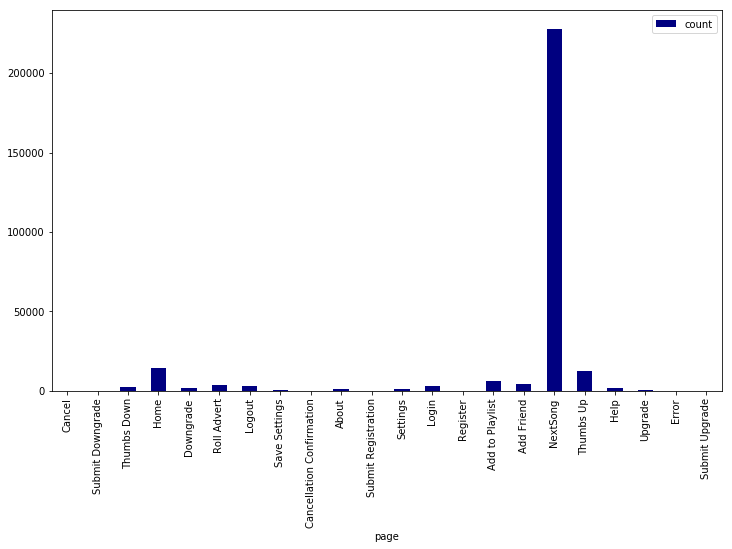

In [24]:
data_log.groupBy("page").count().toPandas().plot(kind= "bar", x="page",color = "navy", figsize=(12,7))

NextSong is the most visited page.

Moreover, we will check how many authentification states in our service. 

In [25]:
# show page unique values
data_log.select("auth").distinct().toPandas()

,auth
0,Logged Out
1,Cancelled
2,Guest
3,Logged In


We can notice that we have four different states. However, Logged Out and Guest will not be used and only Cancelled and Logged In will be explored.

In [26]:
# show page unique values of method
data_log.select("method").distinct().toPandas()

,method
0,PUT
1,GET


In [27]:
# show page unique values of status
data_log.select("status").distinct().toPandas()

,status
0,307
1,404
2,200


Three status values to explain the action feedback 307 redirected, 404 error in page loading, and 200 for a valid action  

In [28]:
data_log.select("location").distinct().show(2)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
+--------------------+
only showing top 2 rows



The location name is too long, we need to just select the state

In [29]:
data_log = data_log.withColumn("state", split(col('location'), ',').getItem(1))
data_log.select("state").distinct().show(5)

+------------+
|       state|
+------------+
|       NE-IA|
|       PA-NJ|
|          WA|
| DC-VA-MD-WV|
|          AL|
+------------+
only showing top 5 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Drop missing values
drop missing values of userID if exists

in this subset there are no missing values f userID but we still chekc for the larger dataset. In addition, we will drop also other empty string Ids 

In [30]:
# check for nan values
nan_values = data_log.filter(data_log["userId"].isNull()).count()
print("we have {} of nan values in userId".format(nan_values))

we have 0 of nan values in userId


In [31]:
# Rows with empty strings in the 'userId' column.
empty_values = data_log.where(data_log.userId == "").count()
print("we have {} of empty string values in userId".format(empty_values))

we have 8346 of empty string values in userId


Now we need to drop bothe empty and nan values

In [32]:
data_log = data_log.dropna(how='any', thresh=None, subset="userId")
data_log = data_log.where(data_log.userId != "")
data_log.count()

278154

In [33]:
# cast userId from string to double
data_log = data_log.withColumn("userId", col("userId").cast(LongType()))
data_log.select("userId").dtypes


[('userId', 'bigint')]

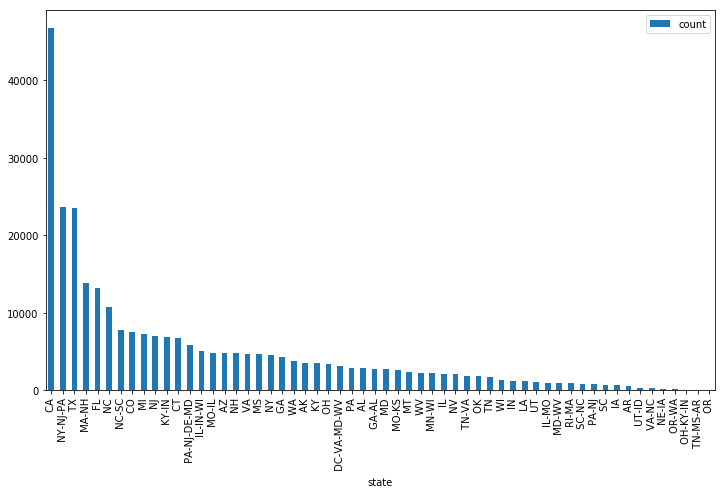

In [34]:
data_log.groupBy("state").count().toPandas().sort_values(by='count', ascending = False).plot(x="state", kind="bar", figsize=(12,7))

From the graph, California, New york, and Texas cities are the most cities using Sparkify. 

### Define the target (Churn)

The churn can be defined using the Cancellation Confirmaion page.

In [35]:
# define churn column
func = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
data_log = data_log.withColumn("churned", func("page"))
data_log.select("churned").groupBy("churned").count().show()

+-------+------+
|churned| count|
+-------+------+
|      1|    52|
|      0|278102|
+-------+------+



In [36]:
# percentage of churned
churned_rate = data_log.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


In [37]:
from pyspark.sql.functions import max as Fmax

data_log = data_log.withColumn("userChurn", Fmax('churned').over(Window.partitionBy("userId")))
data_log.select("userId", "churned", "userChurn").show(5)

+------+-------+---------+
|userId|churned|userChurn|
+------+-------+---------+
|    26|      0|        0|
|    26|      0|        0|
|    26|      0|        0|
|    26|      0|        0|
|    26|      0|        0|
+------+-------+---------+
only showing top 5 rows



In [38]:
data_log.groupBy("userChurn").count().toPandas()

,userChurn,count
0,1,44864
1,0,233290


### User relation to the target

In [39]:
data_log.select(['userId', 'firstName', 'lastName', 'gender', 'location', 'userAgent', 'level','regtime','userChurn']).show(5)

+------+---------+--------+------+-----------------+--------------------+-----+-------------------+---------+
|userId|firstName|lastName|gender|         location|           userAgent|level|            regtime|userChurn|
+------+---------+--------+------+-----------------+--------------------+-----+-------------------+---------+
|    26|    Logan|  Harper|     M|Stockton-Lodi, CA|Mozilla/5.0 (Wind...| free|2018-09-13 05:29:50|        0|
|    26|    Logan|  Harper|     M|Stockton-Lodi, CA|Mozilla/5.0 (Wind...| free|2018-09-13 05:29:50|        0|
|    26|    Logan|  Harper|     M|Stockton-Lodi, CA|Mozilla/5.0 (Wind...| free|2018-09-13 05:29:50|        0|
|    26|    Logan|  Harper|     M|Stockton-Lodi, CA|Mozilla/5.0 (Wind...| free|2018-09-13 05:29:50|        0|
|    26|    Logan|  Harper|     M|Stockton-Lodi, CA|Mozilla/5.0 (Wind...| free|2018-09-13 05:29:50|        0|
+------+---------+--------+------+-----------------+--------------------+-----+-------------------+---------+
only showi

Impact of been male or female on the churn

In [40]:
gender_cancel = data_log.drop_duplicates(['userId', 'gender']).groupby(['userChurn', 'gender']).count().sort("userChurn").toPandas()
gender_cancel

,userChurn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


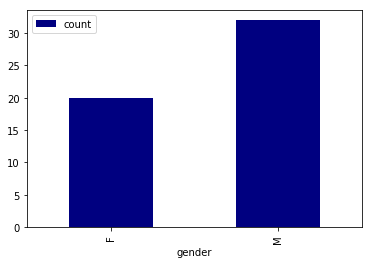

In [41]:
gender_cancel[gender_cancel.userChurn == 1].plot(x= "gender", y="count", kind= "bar", color= "navy")

Males tend to cancel more than females

Who cancels more often, paid or free users?!

In [42]:
free_paid_cancels = data_log.drop_duplicates(['userId', 'level']).groupby(['userChurn', 'level']).count().sort("userChurn").toPandas()
free_paid_cancels

,userChurn,level,count
0,0,free,149
1,0,paid,129
2,1,paid,36
3,1,free,46


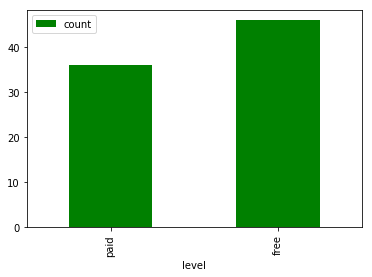

In [43]:
free_paid_cancels[free_paid_cancels.userChurn == 1].plot(x = "level", y="count", kind = "bar", color= "g")

Free users cancel more than paid users, maybe it is related to the trial period.

### Song relation to the target

In [44]:
data_log.select(['artist','song','length', 'userChurn']).show(5)

+-----------------+--------------------+---------+---------+
|           artist|                song|   length|userChurn|
+-----------------+--------------------+---------+---------+
|             null|                null|     null|        0|
|        Aerosmith|       Walk This Way|220.39465|        0|
|    Guns N' Roses|      Garden Of Eden|161.64526|        0|
|The White Stripes|Fell In Love With...|110.47138|        0|
|      Chris Cagle|I Breathe In_ I B...| 244.6624|        0|
+-----------------+--------------------+---------+---------+
only showing top 5 rows



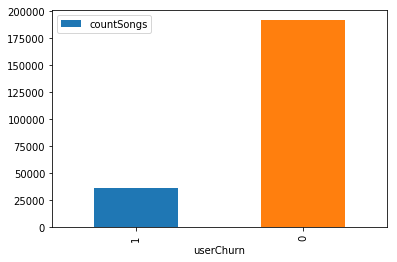

In [45]:
# select only page==NextSong because songs defined only with this type of page action
data_log.where(data_log.page == "NextSong").groupby('userChurn').agg(count('song').alias("countSongs"))\
        .toPandas().plot(x = "userChurn", y = "countSongs", kind = "bar")

In [46]:
data_log.where(data_log.page == "NextSong").groupby('userChurn','userId').agg(count('song').alias("countSongs"))\
        .groupBy("userChurn").agg(avg("countSongs")).toPandas().head()

,userChurn,avg(countSongs)
0,1,699.884615
1,0,1108.173410


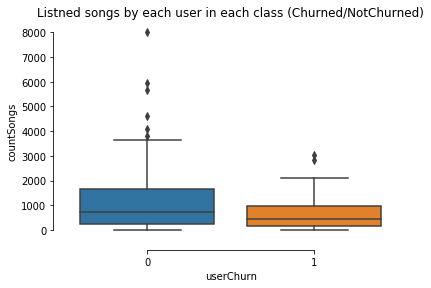

In [47]:
ss = data_log.where(data_log.page == "NextSong").groupby('userChurn','userId').agg(count('song').alias("countSongs"))\
        .toPandas()
ss.head()
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="userChurn", y="countSongs",
            data=ss).set_title("Listned songs by each user in each class (Churned/NotChurned)")
sns.despine(offset=10, trim=True)


In [48]:
data_log.groupby('userChurn').agg(avg('length').alias("avg length")).toPandas()

,userChurn,avg length
0,1,248.632796
1,0,249.209135


In [49]:
data_log.groupby('userChurn','userId')\
    .agg(countDistinct('artist').alias("count_artist"))\
    .groupBy("userChurn").agg({"count_artist":"avg"}).show(5)

+---------+-----------------+
|userChurn|avg(count_artist)|
+---------+-----------------+
|        1|518.6923076923077|
|        0|749.7861271676301|
+---------+-----------------+



In [50]:
data_log.groupBy("userChurn").agg(countDistinct("artist")).show(5)

+---------+----------------------+
|userChurn|count(DISTINCT artist)|
+---------+----------------------+
|        1|                  8402|
|        0|                 16652|
+---------+----------------------+



In [51]:
data_log.where(data_log.page == "NextSong")\
    .select(["userId", "level", "sessionId"])\
    .groupBy(["userId", "level", "sessionId"]).count()\
    .withColumnRenamed("count", "songsPerSession")\
    .groupBy("level","userId").agg({"songsPerSession":"avg"})\
    .groupBy("level").agg({"avg(songsPerSession)": "avg"}).show(5)

+-----+-------------------------+
|level|avg(avg(songsPerSession))|
+-----+-------------------------+
| free|        31.28982093144806|
| paid|       102.62525766710827|
+-----+-------------------------+



In [52]:
user_avg_songs_per_session = data_log.where(data_log.page == "NextSong") \
    .select(["userId", "level", "sessionId"])

user_avg_songs_per_session.show(5)

+------+-----+---------+
|userId|level|sessionId|
+------+-----+---------+
|    30| paid|       29|
|     9| free|        8|
|    30| paid|       29|
|     9| free|        8|
|    30| paid|       29|
+------+-----+---------+
only showing top 5 rows



### Actions relation to the target

In [53]:
#  logs information
data_log.select(['time','sessionId', 'itemInSession', 'page', 'auth',  'method', 'status']).show(5)

+-------------------+---------+-------------+--------+---------+------+------+
|               time|sessionId|itemInSession|    page|     auth|method|status|
+-------------------+---------+-------------+--------+---------+------+------+
|2018-10-01 00:01:57|       29|           50|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:03:00|        8|           79|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:06:34|       29|           51|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:06:56|        8|           80|NextSong|Logged In|   PUT|   200|
|2018-10-01 00:11:16|       29|           52|NextSong|Logged In|   PUT|   200|
+-------------------+---------+-------------+--------+---------+------+------+
only showing top 5 rows



Lets check the impact of song length on the churn

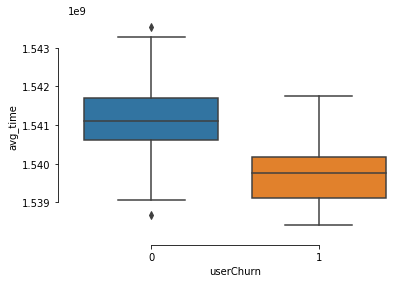

In [54]:
user_churn_avgTime = data_log.groupBy("userId","userChurn").agg(avg("time").alias("avg_time")).toPandas()

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="userChurn", y="avg_time",
            data=user_churn_avgTime)
sns.despine(offset=10, trim=True)

From the previous plot, we can clearly see that the average song length is higher for user who did not churn. While user who churned are likely pass less time in the service.

Now lets check the distribution of items in session for each user related to the target (churn)

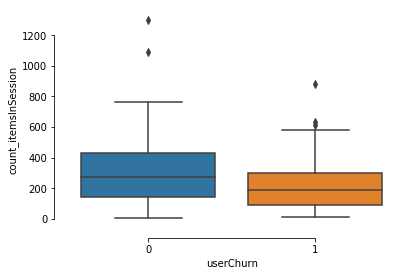

In [55]:
user_bySession = data_log.groupBy("userId","userChurn").agg(countDistinct("itemInSession").alias("count_itemsInSession")).toPandas()
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="userChurn", y="count_itemsInSession",
            data=user_bySession)
sns.despine(offset=10, trim=True)

Not churned users have more items compared to churned users.

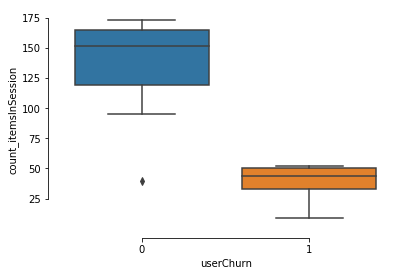

In [56]:
user_bySession = data_log.groupBy("page","userChurn").agg(countDistinct("userId").alias("count_itemsInSession")).toPandas()
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="userChurn", y="count_itemsInSession",
            data=user_bySession)
sns.despine(offset=10, trim=True)

In [57]:
data_log.groupBy("page","userId","userChurn").count().toPandas().head()

,page,userId,userChurn,count
0,Home,26,0,17
1,NextSong,26,0,255
2,Add to Playlist,26,0,8
3,Roll Advert,26,0,22
4,Add Friend,26,0,6


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Define features

* Given features: gender, location, userAgent, level
* Toal songs played by each user
* Distinct songs by user
* Distinct artists by user
* Ratio of paid actions (paid actions /(paid+free)actions )
* subscription length
* number of errors pages
* number of help page visit
* number of GETs/(number of PUTs + number of GETs)
* average itemInSession by user
* average song per session




In [58]:
# first get the latest level
def add_last_level(data_log, features):
    """function to 'last level' columns to the same data_log"""
    
    latest_level = data_log.orderBy("time", ascending = False).groupBy("userId").agg(first("level")\
                                                            .alias("last_level")).distinct()
    features = features.join(latest_level, on= "userId")
    return features

In [59]:
def add_tot_songs(data_log, features):
    """function to add total songs 'tot_song' columns to the features df"""
    
    tot_songs = data_log.groupBy("userId").agg(count("song").alias("total_song")).distinct()
    features = features.join(tot_songs, on= "userId")
    return features



In [60]:
def add_distinct_songs(data_log, features):
    """function to add distinct songs 'distinct_songs' columns to the features df"""
    
    dist_songs = data_log.groupBy("userId").agg(countDistinct("song").alias("distinct_songs")).distinct()
    features = features.join(dist_songs, on= "userId")
    return features

In [61]:
def add_distinct_artists(data_log, features):
    """function to add distinct songs 'distinct_artists' columns to the features df"""
    
    dist_songs = data_log.groupBy("userId").agg(countDistinct("artist").alias("distinct_artists")).distinct()
    features = features.join(dist_songs, on= "userId")
    return features

In [62]:
def add_get_perecentage(data_log, features):
    """"""
    
    prop = data_log.groupBy("userId", "method").count().withColumn("get_percentage", col("count")/F.sum(col("count"))\
                                                               .over(Window.partitionBy("userId")))
                                                            
    get_perce = prop.where(prop.method == "GET").drop("method","count")
    features = features.join(get_perce, on= "userId")
    return features

In [63]:
def add_paid_perecentage(data_log, features):
    """"""
    
    prop = data_log.groupBy("userId", "level").count().withColumn("paid_percentage", col("count")/F.sum(col("count"))\
                                                               .over(Window.partitionBy("userId")))
                                                            
    get_perce = prop.where(prop.level == "paid").drop("level","count")
    features = features.join(get_perce, on= "userId")
    return features

In [64]:
def add_psubscription_length(data_log, features):
    """"""
    
    sub_length = data_log.groupBy("userId").agg((F.last("ts")-F.first("ts")).alias('subscr_length'))

    features = features.join(sub_length, on= "userId")
    return features

In [65]:
def add_error_page(data_log, features):
    """"""
    
    err_page = data_log.filter(col("page")=="Error").groupBy("userId").agg(count("page").alias("num_errors_page"))

    features = features.join(err_page, on= "userId")
    return features

In [66]:
def add_help_page(data_log, features):
    """"""
    
    err_page = data_log.filter(col("page")=="Help").groupBy("userId").agg(count("page").alias("num_help_page"))

    features = features.join(err_page, on= "userId")
    return features

In [67]:
def add_avg_item_session(data_log, features):
    """"""
    
    avg_item = data_log.groupBy("userId", "sessionId").agg(count("itemInSession").alias("count"))\
                                        .groupBy("userId").agg(avg("count").alias("avg_item_session"))

    features = features.join(avg_item, on= "userId")
    return features

In [68]:
def add_avg_song_session(data_log, features):
    """"""
    
    avg_song = data_log.groupBy("userId", "sessionId").agg(count("song").alias("count"))\
                                        .groupBy("userId").agg(avg("count").alias("avg_song_session"))

    features = features.join(avg_song, on= "userId")
    return features

In [69]:
#Create features DataFrame.

features = data_log.select("userId","gender", "state", "userChurn").distinct()
features.show(5)

+------+------+---------+---------+
|userId|gender|    state|userChurn|
+------+------+---------+---------+
|    26|     M|       CA|        0|
|    29|     M|       CA|        1|
|    65|     M|       NH|        0|
|100016|     M|    MO-IL|        0|
|100012|     M| IL-IN-WI|        1|
+------+------+---------+---------+
only showing top 5 rows



In [70]:
# add features
ff = add_last_level(data_log, features)
ff = add_tot_songs(data_log, ff)
ff = add_distinct_songs(data_log, ff)
ff= add_distinct_artists(data_log, ff)
ff = add_get_perecentage(data_log, ff)
ff = add_paid_perecentage(data_log, ff)
ff = add_psubscription_length(data_log, ff)
ff = add_error_page(data_log, ff)
ff = add_help_page(data_log, ff)
ff = add_avg_item_session(data_log, ff)
ff = add_avg_song_session(data_log, ff)
ff.toPandas().head(5)

,userId,gender,state,userChurn,last_level,total_song,distinct_songs,distinct_artists,get_percentage,paid_percentage,subscr_length,num_errors_page,num_help_page,avg_item_session,avg_song_session
0,100016,M,MO-IL,0,free,530,493,431,0.076803,0.847962,4927081000,1,3,79.750000,66.250000
1,54,F,WA,1,paid,2841,2414,1744,0.074775,0.831830,3697678000,1,17,92.891892,76.783784
2,113,F,NC-SC,0,paid,1585,1429,1111,0.059103,0.948285,5180700000,3,7,78.958333,66.041667
3,155,F,MA-NH,0,paid,820,759,643,0.070858,0.856287,2231525000,3,9,167.000000,136.666667
4,200008,F,NC-SC,0,paid,1669,1505,1159,0.062624,0.988072,4940593000,3,4,134.133333,111.266667


In [72]:
ff.toPandas().to_csv("processed.csv")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [73]:
# load data
# load data

path = "processed_data.json"
df = spark.read.json(path)
# rename userChurn to label

df = df.withColumnRenamed("userChurn", "label")
df.toPandas().head()

,avg_item_session,avg_song_session,distinct_artists,distinct_songs,gender,get_percentage,last_level,num_errors_page,num_help_page,paid_percentage,state,subscr_length,total_song,label,userId
0,115.526316,95.105263,1216,1606,F,0.068793,paid,3,19,0.849658,FL,4969842000,1807,0,20
1,98.611111,82.777778,1062,1335,M,0.052394,paid,2,9,0.941972,MS,3795281000,1490,1,70
2,51.571429,40.000000,248,266,M,0.077562,paid,1,4,0.966759,CA,3490662000,280,0,300014
3,55.468750,44.281250,1018,1272,M,0.103662,paid,1,5,0.380282,CA,5270203000,1417,0,30
4,90.574468,76.021277,2073,2961,F,0.066949,paid,7,20,0.969697,VA,5191625000,3573,0,42


In [74]:
# post process data

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [75]:
# pipeline
num_cols = []

for field in df.schema.fields :
    if field.dataType!=StringType():
        num_cols.append(field.name)
num_cols = [x for x in num_cols if x not in ['label', 'userId']]

def get_data(df, num_cols):
    idx_gender = StringIndexer(inputCol='gender', outputCol='gender_idx')
    idx_last_level = StringIndexer(inputCol='last_level', outputCol='last_level_idx')

    num_cols = num_cols+["gender_idx", "last_level_idx"]
    # normalize data 


    assembler = VectorAssembler(inputCols=num_cols, outputCol='num_cols')
    scaler = StandardScaler(inputCol='num_cols', outputCol ='features', withStd=True, withMean=True)
    pipeline = Pipeline(stages=[idx_gender, idx_last_level,assembler, scaler ])
    df_pipeline = pipeline.fit(df).transform(df)
    data = df_pipeline.select(df_pipeline.features, df_pipeline.label)
    train, test = data.randomSplit([0.8, 0.2], seed = 36)
    return train, test
train, test = get_data(df, num_cols)

In [76]:
def evaluate(model, test):
    # Fit and calculate predictions
    results = model.transform(test)
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    print('The F1 score on the test set is {:.2%}'.format(f1_score)) 

    auc_evaluator = BinaryClassificationEvaluator()
    metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
    print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))
    return

def featImportance(bestModel):
    FeatImportance = dict()
    for i in range(len(bestModel.featureImportances)):
        FeatImportance[df.columns[i]] = bestModel.featureImportances[i]
    return FeatImportance


### Logistic regression

In [77]:
# model 
lr = LogisticRegression()
# train and evaluate
lr = lr.fit(train)
evaluate(lr, test)

The F1 score on the test set is 80.65%
The areaUnderROC on the test set is 92.00%


### Logistic regression with hyperparameters tuning

In [ ]:
# Logistic regression with cross validation
lr = LogisticRegression()

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 40, 100]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.05, 0.1] ) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=5)
lr_crossval = lr_crossval.fit(train)
# train and evaluate
evaluate(lr_crossval,test)

The F1 score on the test set is 92.00%


In [ ]:
bestModel = lr_crossval.bestModel
print('Best parameters : max iteration:{}, elasticNetParam:{}'.\
      format(bestModel._java_obj.getMaxIter(), bestModel._java_obj.getElasticNetParam()))

### Random forest

In [ ]:
rf = RandomForestClassifier()
# train and evaluate
rf = rf.fit(train)
evaluate(rf, test)

### Random forest paramters tuning

In [81]:
# RF with cross validation
rf = RandomForestClassifier()

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [0, 2, 5]) \
    .addGrid(rf.numTrees, [50, 200, 500] ) \
    .build()

rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=5)
rf_crossval = rf_crossval.fit(train)
# train and evaluate
evaluate(rf_crossval, test)

The F1 score on the test set is 79.39%
The areaUnderROC on the test set is 79.00%


In [82]:
bestModel = rf_crossval.bestModel
print('Best parameters : max depth:{}, numTrees:{}'.\
      format(bestModel._java_obj.getMaxDepth(), bestModel._java_obj.getNumTrees()))

Best parameters : max depth:2, numTrees:500


In [83]:
rfFeatImportance = featImportance(bestModel)
rfFeatImportance

{'avg_item_session': 0.15083789090102359,
 'avg_song_session': 0.11381543257281057,
 'distinct_artists': 0.053570945390445712,
 'distinct_songs': 0.040232442422228287,
 'gender': 0.068281379595664535,
 'get_percentage': 0.010658981298839588,
 'last_level': 0.021215245203514213,
 'num_errors_page': 0.073998737781113225,
 'num_help_page': 0.40046498548671183,
 'paid_percentage': 0.059376856617258382,
 'state': 0.0053475705971226042,
 'subscr_length': 0.0021995321332673678}

### Decision trees

In [86]:
dt = DecisionTreeClassifier()
# train and evaluate
dt =dt.fit(train)
evaluate(dt, test)

The F1 score on the test set is 88.39%
The areaUnderROC on the test set is 84.00%


### Decision trees parameters tuning

In [87]:
# Dt with cross validation
dt = DecisionTreeClassifier()

dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10, 20, 30]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100] ) \
    .build()

dt_crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=5)
dt_crossval =dt_crossval.fit(train)
# train and evaluate
evaluate(dt_crossval, test)

The F1 score on the test set is 88.90%
The areaUnderROC on the test set is 94.50%


In [88]:
bestModel = dt_crossval.bestModel
print('Best parameters : max depth:{}, max bins:{}'.\
      format(bestModel._java_obj.getMaxDepth(), bestModel._java_obj.getMaxBins()))

Best parameters : max depth:5, max bins:20


In [89]:
# prints feature importances
import pandas as pd


dtFeatImportance = featImportance(bestModel)
dtFeatImportance

{'avg_item_session': 0.12576832151300227,
 'avg_song_session': 0.08085106382978724,
 'distinct_artists': 0.13937961172003727,
 'distinct_songs': 0.0,
 'gender': 0.0,
 'get_percentage': 0.041922773837667453,
 'last_level': 0.0,
 'num_errors_page': 0.10741083359029709,
 'num_help_page': 0.50466739550920869,
 'paid_percentage': 0.0,
 'state': 0.0,
 'subscr_length': 0.0}

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.